In [1]:
!pip install control -q
import control as ct
import numpy as np
import matplotlib.pyplot as plt

# Define um padrão visual mais limpo para os gráficos
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['font.size'] = 14
plt.style.use('seaborn-v0_8-whitegrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 13.0 MB/s eta 0:00:00


### Simulação 1: Rejeição de Perturbação em um Sistema de Controle de Velocidade (Exemplo 4.4)

Vamos simular o Exemplo 4.4 para comparar o desempenho de um sistema de controle de velocidade de motor CC em **malha aberta** vs. **malha fechada** quando sujeito a uma perturbação de carga (um torque súbito).

O objetivo é visualizar como a realimentação com um tacômetro reduz drasticamente o efeito dessa perturbação na velocidade final do motor, mantendo-a próxima do valor desejado (que, neste caso, é zero, pois estamos analisando apenas o efeito da perturbação).

--- Sistema em Malha Aberta ---
Função de Transferência ω(s)/Tp(s):
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

     -1
  ---------
  2 s + 1.5
Desvio de velocidade em regime estacionário (Malha Aberta): -0.6650 rad/s

--- Sistema em Malha Fechada ---
Função de Transferência ω(s)/Tp(s):
<TransferFunction>: sys[2]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

      -1
  -----------
  2 s + 541.5
Desvio de velocidade em regime estacionário (Malha Fechada): -0.0018 rad/s


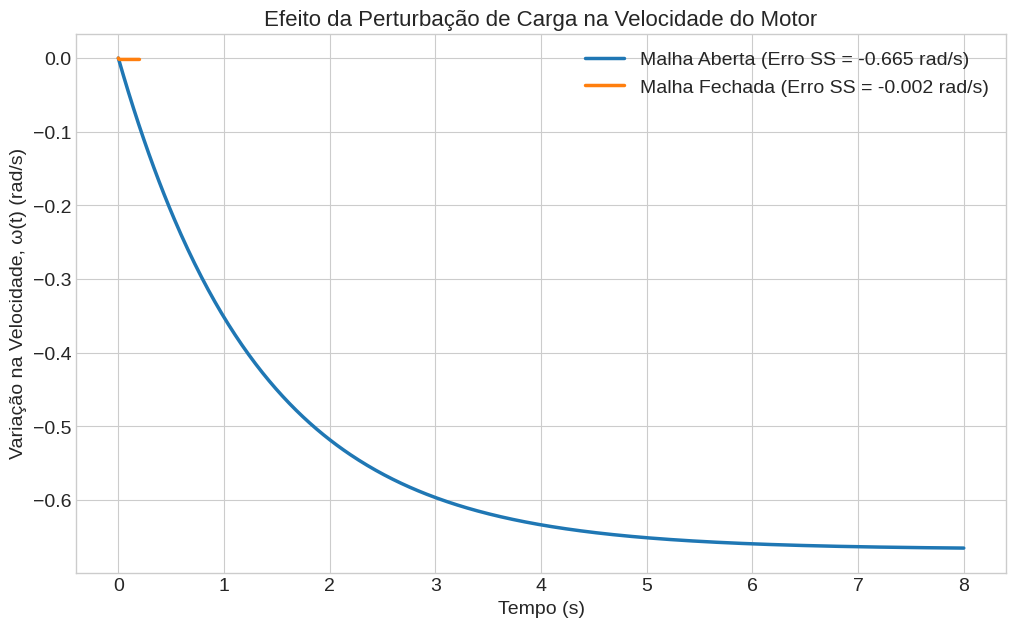


ANÁLISE: O sistema em malha fechada é aproximadamente 360 vezes mais eficaz em rejeitar a perturbação de carga.
Observe como a realimentação não só diminuiu drasticamente o erro, como também tornou a resposta muito mais rápida.


In [2]:
# --- Parâmetros do Sistema (Motor CC, Tabela 4.2) ---
Ra = 1.0       # Resistência da armadura (Ohm)
Km = 10.0      # Constante de torque do motor (Nm/A)
J = 2.0        # Inércia da carga (kg.m^2)
b = 0.5        # Coeficiente de atrito viscoso (Nm.s/rad)
Kce = 0.1      # Constante da força contra-eletromotriz (V.s/rad)
Ka = 54.0      # Ganho do amplificador do controlador
Kt = 1.0       # Ganho do tacômetro (V.s/rad)

# --- Análise em Malha Aberta ---
# FT da Perturbação (Tp) para a Velocidade (omega): G_p(s) = -1 / (J*s + b + Kce*Km/Ra)
num_ma = [-1]
den_ma = [J, b + (Kce * Km) / Ra]
sys_ma = ct.tf(num_ma, den_ma)

print("--- Sistema em Malha Aberta ---")
print("Função de Transferência ω(s)/Tp(s):")
print(sys_ma)

# Simula a resposta a uma perturbação em degrau unitário (Tp(s) = 1/s)
t_ma, y_ma = ct.step_response(sys_ma, T=np.linspace(0, 8, 500))
erro_ss_ma = y_ma[-1]
print(f"Desvio de velocidade em regime estacionário (Malha Aberta): {erro_ss_ma:.4f} rad/s")

# --- Análise em Malha Fechada ---
# FT da Perturbação (Tp) para a Velocidade (omega): G_p_mf(s) = -Ra / (Ra*J*s + Ra*b + Km*(Kce + Ka*Kt))
num_mf = [-Ra]
den_mf = [Ra*J, Ra*b + Km*Kce + Km*Ka*Kt]
sys_mf = ct.tf(num_mf, den_mf)

print("\n--- Sistema em Malha Fechada ---")
print("Função de Transferência ω(s)/Tp(s):")
print(sys_mf)

# Simula a resposta a uma perturbação em degrau unitário
t_mf, y_mf = ct.step_response(sys_mf, T=np.linspace(0, 0.2, 500))
erro_ss_mf = y_mf[-1]
print(f"Desvio de velocidade em regime estacionário (Malha Fechada): {erro_ss_mf:.4f} rad/s")

# --- Comparação Gráfica ---
plt.figure()
plt.plot(t_ma, y_ma, label=f'Malha Aberta (Erro SS = {erro_ss_ma:.3f} rad/s)', linewidth=2.5)
plt.plot(t_mf, y_mf, label=f'Malha Fechada (Erro SS = {erro_ss_mf:.3f} rad/s)', linewidth=2.5)
plt.title('Efeito da Perturbação de Carga na Velocidade do Motor', fontsize=16)
plt.xlabel('Tempo (s)')
plt.ylabel('Variação na Velocidade, ω(t) (rad/s)')
plt.legend()
plt.grid(True)
plt.show()

# --- Conclusão da Simulação 1 ---
fator_melhora = abs(erro_ss_ma / erro_ss_mf)
print(f"\nANÁLISE: O sistema em malha fechada é aproximadamente {fator_melhora:.0f} vezes mais eficaz em rejeitar a perturbação de carga.")
print("Observe como a realimentação não só diminuiu drasticamente o erro, como também tornou a resposta muito mais rápida.")

### Simulação 2: O Trade-off de Projeto (Exemplo 4.5 - Máquina de Perfuração)

Agora, vamos investigar o efeito de variar o **ganho do controlador (K)**. Esta simulação, baseada no Exemplo 4.5, ilustra um dos trade-offs mais comuns em engenharia de controle:

* **Resposta Transitória vs. Rejeição à Perturbação**

Analisaremos dois cenários com ganhos diferentes (`K=20` e `K=100`) para observar como a escolha do ganho afeta:
1.  A resposta do sistema a um comando de entrada (um degrau na posição desejada).
2.  A capacidade do sistema de rejeitar uma perturbação externa.

Esperamos ver que um ganho mais alto melhora a rejeição à perturbação, mas ao custo de uma pior resposta transitória (maior *overshoot*).

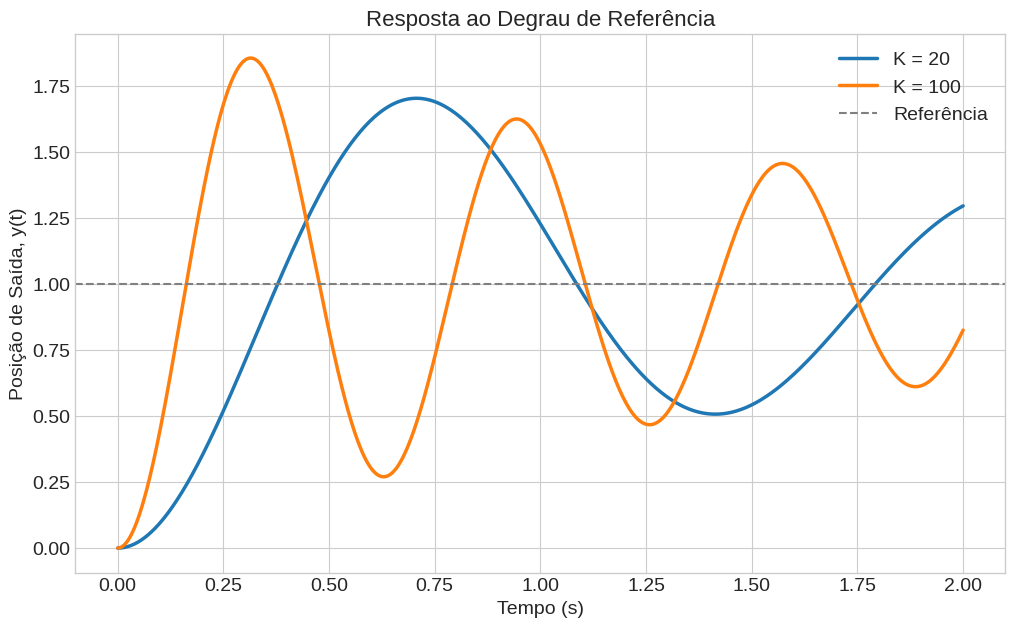

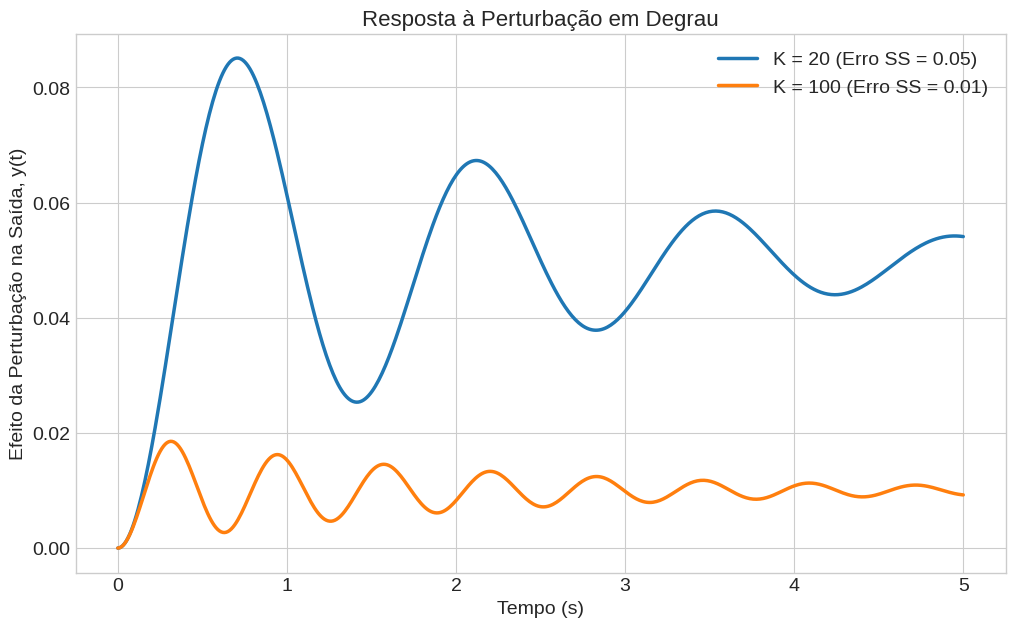


ANÁLISE: Fica claro o compromisso no projeto.
-> Ganho baixo (K=20): Resposta à referência com pouco overshoot (4%), mas rejeição à perturbação mais fraca (erro de 5%).
-> Ganho alto (K=100): Excelente rejeição à perturbação (erro de 1%), mas a resposta à referência tem um overshoot elevado e inaceitável (22%).

A escolha do ganho 'K' dependerá das especificações do projeto: o que é mais importante, seguir a referência suavemente ou rejeitar distúrbios externos?


In [3]:
# --- Definição da Planta (Processo) ---
# G(s) = 1 / (s*(s+1))
num_g = [1]
den_g = [1, 1, 0]
G_planta = ct.tf(num_g, den_g)

# Ganhos do controlador a serem testados
K_valores = [20, 100]

# Dicionário para armazenar os resultados
resultados = {}

for K in K_valores:
    # Controlador Proporcional: Gc(s) = K
    Gc = ct.tf([K], [1])

    # --- Cálculo das Funções de Transferência em Malha Fechada ---
    # 1. FT para a entrada de referência: T(s) = Y(s)/R(s)
    T_ref = ct.feedback(Gc * G_planta, 1)

    # 2. FT para a perturbação: Y(s)/Tp(s)
    T_pert = ct.feedback(G_planta, Gc)

    # Armazena os sistemas no dicionário
    resultados[K] = {'T_ref': T_ref, 'T_pert': T_pert}


# --- GRÁFICO 1: Resposta à Entrada de Referência ---
plt.figure()
for K, data in resultados.items():
    t, y = ct.step_response(data['T_ref'], T=np.linspace(0, 2, 500))
    plt.plot(t, y, label=f'K = {K}', linewidth=2.5)

plt.title('Resposta ao Degrau de Referência', fontsize=16)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição de Saída, y(t)')
plt.axhline(1, color='gray', linestyle='--', label='Referência')
plt.legend()
plt.grid(True)
plt.show()


# --- GRÁFICO 2: Resposta à Perturbação ---
plt.figure()
for K, data in resultados.items():
    t, y = ct.step_response(data['T_pert'], T=np.linspace(0, 5, 500))
    erro_ss = y[-1]
    plt.plot(t, y, label=f'K = {K} (Erro SS = {erro_ss:.2f})', linewidth=2.5)

plt.title('Resposta à Perturbação em Degrau', fontsize=16)
plt.xlabel('Tempo (s)')
plt.ylabel('Efeito da Perturbação na Saída, y(t)')
plt.legend()
plt.grid(True)
plt.show()

# --- Conclusão da Simulação 2 ---
print("\nANÁLISE: Fica claro o compromisso no projeto.")
print("-> Ganho baixo (K=20): Resposta à referência com pouco overshoot (4%), mas rejeição à perturbação mais fraca (erro de 5%).")
print("-> Ganho alto (K=100): Excelente rejeição à perturbação (erro de 1%), mas a resposta à referência tem um overshoot elevado e inaceitável (22%).")
print("\nA escolha do ganho 'K' dependerá das especificações do projeto: o que é mais importante, seguir a referência suavemente ou rejeitar distúrbios externos?")